In [3]:
import pandas as pd
import nltk
import pickle

import glob
import pytextrank
from collections import Counter
from operator import itemgetter 
import string
from os import path
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora,models
from gensim.models import LdaModel, LsiModel

# spacy for lemmatization
import spacy
from spacy.lang.en import English

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Widen the dataframe to show the long cells
pd.set_option('display.max_colwidth', 500)

# 0. Import the 2588 cases

In [4]:
# Import cases as dataframe, including titles
df = pd.read_pickle('all_cases.pickle')
df = pd.DataFrame(list(df), columns=['content'])
df.head()

,content
0,"raghupathi, wullianallur 4/28/2019 for educational use only montana environmental information center v. united states..., not reported in fed.... 2013 wl 11323877 only the westlaw citation is currently available. united states district court, d. montana, great falls division. montana environmental information center, et al. plaintiffs, v. united states bureau of land management, et al. federal defendants, american petroleum institute, et al., defendant–intervenors. v. no. cv-11-1..."
1,"raghupathi, wullianallur 4/28/2019 for educational use only exxon mobil corporation v. attorney general, 479 mass. 312 94 n.e.3d 786 479 mass. 312 supreme judicial court of massachusetts, suffolk.. exxon mobil corporation v. attorney general. sjc–12376 | argued december 5, 2017. | decided april 13, 2018. synopsis background: fossil fuel company moved to set aside attorney general civil investigative demand for documents and information relating to company knowledge and a..."
2,"raghupathi, wullianallur 4/28/2019 for educational use only people of state of california v. general motors corp., not reported in f.supp.2d 2007 wl 2726871 only the westlaw citation is currently available. united states district court, n.d. california. people of the state of california, plaintiff, v. general motors corporation, et al., defendants. no. c06–05755 mjj. | sept. 17, 2007. attorneys and law firms kenneth p. alex, california department of justice, harrison martin po..."
3,"raghupathi, wullianallur 4/28/2019 for educational use only national audubon society v. kempthorne, slip copy 2006 wl 8438583 only the westlaw citation is currently available. united states district court, d. alaska. national audubon society; alaska wilderness league; center for biological diversity; natural resources defense council; northern alaska environmental center; sierra club; and the wilderness society, plaintiffs, v. dirk kempthorne, 1 secretary of the interior; henri bis..."
4,"raghupathi, wullianallur 4/28/2019 for educational use only alaska oil and gas ass'n v. pritzker, not reported in f.supp.3d 2014 wl 3726121 only the westlaw citation is currently available. united states district court, d. alaska. alaska oil and gas association, et al., plaintiffs, v. penny pritzker, u.s. secretary of commerce, et al., defendants. state of alaska, plaintiff, v. national marine fisheries service, et al., defendants. north slope borough, et al., plaintiffs, v. p..."


In [5]:
# Convert dataframe to list
data2 = df.content.values.tolist()
data2[0]

"raghupathi, wullianallur 4/28/2019  for educational use only  montana environmental information center v. united states..., not reported in fed....  2013 wl 11323877  only the westlaw citation is currently available.  united states district court, d. montana,  great falls division.  montana environmental information center, et al. plaintiffs,  v.  united states bureau of land management, et al. federal defendants,  american petroleum institute, et al., defendant–intervenors.  v.  no. cv-11-15-gf-seh  |  filed 06/14/2013  attorneys and law firms  erik  schlenker–goodrich,  taos,  nm,  sarah  k.  mcmillan,  wildearth  guardians,  missoula,  mt,  shiloh  silvan hernandez, helena, mt, for plaintiffs.  ruth  ann  storey,  u.s.  department  of  justice,  washington,  dc,  mark  steger  smith,  office  of  the  u.s.  attorney, billings, mt, for federal defendant.  william w. mercer, holland & hart, billings, mt, hadassah m. reimer, holland & hart, jackson, wy, for intervenor defendant.  sam 

# 1. Clean text

In [6]:
# Import NLTK Stop words and law cases stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'plaintiff', 'court', 'attorney', 'defendant'])

In [7]:
# Remove the non-use text contents
def processtext(data):
    data3 = re.sub("\n"," ",data).split("  ")
    for i in range(len(data3)):
        data3[i] = re.sub("\n"," ", data3[i]).strip()
        data3[i] = re.sub("(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]","", data3[i])
        data3[i] = re.sub("(\(sc.Search\)).+", "", data3[i])
        data3[i] = re.sub(".pdfRaghupathi, Wullianallur ", " ", data3[i])
        data3[i] = re.sub("For Educational Use Only", "", data3[i])
        data3[i] = re.sub("Plaintiffs", "", data3[i]) 
        data3[i] = re.sub("Plaintiff", "", data3[i]) 
        data3[i] = re.sub("plaintiff", "", data3[i]) 
        data3[i] = re.sub("Court", "", data3[i]) 
        data3[i] = re.sub("Defendants", "", data3[i]) 
        data3[i] = re.sub("Defendant", "", data3[i]) 
        data3[i] = re.sub("defendant", "", data3[i]) 
        data3[i] = re.sub("state", "", data3[i]) 
        data3[i] = re.sub("government", "", data3[i]) 
        data3[i] = re.sub("claim", "", data3[i]) 
        data3[i] = re.sub("law", "", data3[i]) 
        data3[i] = re.sub("case", "", data3[i]) 
        data3[i] = re.sub("federal", "", data3[i]) 
        data3[i] = re.sub("regulation", "", data3[i]) 
        data3[i] = re.sub("original", "", data3[i]) 
        data3[i] = re.sub("from", "", data3[i]) 
        data3[i] = re.sub("subject", "", data3[i]) 
        data3[i] = re.sub("use", "", data3[i]) 
        data3[i] = re.sub("Raghupathi", "", data3[i]) 
        data3[i] = re.sub("Wullianallur", "", data3[i]) 
    data3 = list(filter(None, data3))
    data3 =[i for i in data3 if "U.S.P.Q.2d" not in i]
    data3 =[i for i in data3 if "2019 Thomson Reuters" not in i]
    data3 =[i for i in data3 if "2019-1 Trade Cases P 80,389" not in i]
    return data3

In [8]:
# Clean each lists in the "data2" list
data=[]
for j in data2:
    data.append(processtext(j))

data[0]

['raghupathi, wullianallur 4/28/2019',
 'for educational  only',
 'montana environmental information center v. united s..., not reported in fed....',
 '2013 wl 11323877',
 'only the west citation is currently available.',
 'united s district court, d. montana,',
 'great falls division.',
 'montana environmental information center, et al. s,',
 'v.',
 'united s bureau of land management, et al.  s,',
 'american petroleum institute, et al., –intervenors.',
 'v.',
 'no. cv-11-15-gf-seh',
 '|',
 'filed 06/14/2013',
 'attorneys and  firms',
 'erik',
 'schlenker–goodrich,',
 'taos,',
 'nm,',
 'sarah',
 'k.',
 'mcmillan,',
 'wildearth',
 'guardians,',
 'missoula,',
 'mt,',
 'shiloh',
 'silvan hernandez, helena, mt, for s.',
 'ruth',
 'ann',
 'storey,',
 'u.s.',
 'department',
 'of',
 'justice,',
 'washington,',
 'dc,',
 'mark',
 'steger',
 'smith,',
 'office',
 'of',
 'the',
 'u.s.',
 'attorney, billings, mt, for  .',
 'william w. mercer, holland & hart, billings, mt, hadassah m. reimer, holl

In [7]:
# 404 cases in total
len(data)

404

In [9]:
# Convert a whole "data" list into a list of tokens.This lowercases, tokenizes, de-accents each string
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['raghupathi', 'wullianallur', 'for', 'educational', 'only', 'montana', 'environmental', 'information', 'center', 'united', 'not', 'reported', 'in', 'fed', 'wl', 'only', 'the', 'west', 'citation', 'is', 'currently', 'available', 'united', 'district', 'court', 'montana', 'great', 'falls', 'division', 'montana', 'environmental', 'information', 'center', 'et', 'al', 'united', 'bureau', 'of', 'land', 'management', 'et', 'al', 'american', 'petroleum', 'institute', 'et', 'al', 'intervenors', 'no', 'cv', 'gf', 'seh', 'filed', 'attorneys', 'and', 'firms', 'erik', 'schlenker', 'goodrich', 'taos', 'nm', 'sarah', 'mcmillan', 'wildearth', 'guardians', 'missoula', 'mt', 'shiloh', 'silvan', 'hernandez', 'helena', 'mt', 'for', 'ruth', 'ann', 'storey', 'department', 'of', 'justice', 'washington', 'dc', 'mark', 'steger', 'smith', 'office', 'of', 'the', 'attorney', 'billings', 'mt', 'for', 'william', 'mercer', 'holland', 'hart', 'billings', 'mt', 'hadassah', 'reimer', 'holland', 'hart', 'jackson', 'wy'

# 2. Bigram and Trigram Models

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['raghupathi_wullianallur', 'for', 'educational', 'only', 'montana', 'environmental', 'information', 'center', 'united', 'not', 'reported', 'in', 'fed', 'wl', 'only', 'the', 'west_citation', 'is', 'currently', 'available', 'united', 'district', 'court', 'montana', 'great', 'falls', 'division', 'montana', 'environmental', 'information', 'center', 'et_al', 'united', 'bureau', 'of', 'land', 'management', 'et_al', 'american_petroleum_institute', 'et_al', 'intervenors', 'no', 'cv_gf', 'seh', 'filed', 'attorneys', 'and', 'firms', 'erik', 'schlenker', 'goodrich', 'taos_nm', 'sarah', 'mcmillan', 'wildearth_guardians', 'missoula_mt', 'shiloh', 'silvan', 'hernandez', 'helena_mt', 'for', 'ruth', 'ann', 'storey', 'department', 'of', 'justice_washington_dc', 'mark_steger_smith', 'office', 'of', 'the', 'attorney_billings_mt', 'for', 'william', 'mercer', 'holland_hart', 'billings_mt', 'hadassah', 'reimer', 'holland_hart', 'jackson', 'wy', 'for', 'intervenor', 'sam', 'haddon', 'united', 'district', 'j

In [11]:
from spacy.cli import download
print(download('en'))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✘ Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\yueyu\anaconda3_new\lib\site-packages\en_core_web_sm -->
C:\Users\yueyu\anaconda3_new\lib\site-packages\spacy\data\en
⚠ Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')
None


In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Increase the nlp.max_length over 1000000 default limit
nlp.max_length = 1100000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'ADV'])


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
print(data_lemmatized[:2])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

# 3. Try LDA for 20 topics

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                            
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.019*"impact" + 0.019*"action" + 0.018*"agency" + 0.016*"oil" + 0.016*"gas" + 0.015*"blm" + 0.014*"land" + 0.014*"environmental" + 0.014*"analysis" + 0.012*"lease"'), (1, '0.011*"section" + 0.010*"permit" + 0.010*"jurisdiction" + 0.008*"cost" + 0.007*"action" + 0.007*"statute" + 0.007*"duty" + 0.007*"emission" + 0.007*"proceeding" + 0.007*"educational"'), (2, '0.022*"action" + 0.016*"agency" + 0.013*"population" + 0.012*"specie" + 0.009*"opinion" + 0.008*"effect" + 0.008*"recovery" + 0.007*"survival" + 0.007*"biological" + 0.007*"environmental"'), (3, '0.013*"specie" + 0.012*"evidence" + 0.011*"nmf" + 0.011*"year" + 0.009*"also" + 0.009*"significant" + 0.008*"decision" + 0.008*"range" + 0.008*"status" + 0.007*"review"'), (4, '0.021*"action" + 0.016*"injury" + 0.014*"agency" + 0.012*"motion" + 0.009*"interest" + 0.009*"project" + 0.009*"also" + 0.008*"decision" + 0.008*"educational" + 0.007*"member"'), (5, '0.035*"forest" + 0.029*"service" + 0.027*"project" + 0.015*"area" + 0.015

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2581089385805395

Coherence Score:  0.39060312454954094


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.146435 -0.050583       1        1  10.957202
10    -0.114071  0.101837       2        1  10.856582
5     -0.006572 -0.159999       3        1   8.248279
12    -0.014425 -0.059527       4        1   8.170004
7     -0.106413 -0.010721       5        1   7.207902
17     0.089971 -0.148199       6        1   6.786112
16     0.088798 -0.066584       7        1   6.602283
4     -0.088658 -0.076232       8        1   5.965504
0     -0.090276 -0.147525       9        1   5.771654
14     0.011205  0.065430      10        1   5.320457
2      0.053932 -0.156009      11        1   4.544885
6     -0.039876  0.052047      12        1   3.697061
15    -0.198936  0.051033      13        1   3.645761
13     0.141086  0.161267      14        1   3.253523
9     -0.121266  0.171898      15        1   2.805338
11    -0.024174  0.177600      16        1   1.623677
19     0.130025  0.029004      17        1   1.432535
8      0.151137 -0.073335      18        1   1.287820
1      0.046897  0.156589      19        1   1.250647
3      0.238051 -0.017990      20        1   0.572764, topic_info=          Term          Freq         Total Category  logprob  loglift
118   document   4015.000000   4015.000000  Default  30.0000  30.0000
285    project  13859.000000  13859.000000  Default  29.0000  29.0000
152     forest   3680.000000   3680.000000  Default  28.0000  28.0000
768    service   6434.000000   6434.000000  Default  27.0000  27.0000
1699    specie   4424.000000   4424.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
16      agency     35.727791  10972.212891  Topic20  -5.1520  -0.5647
197      issue     26.770964   4944.522461  Topic20  -5.4406  -0.0563
1502   habitat     23.311573   2301.844971  Topic20  -5.5790   0.5699
213     likely     22.904613   2064.201172  Topic20  -5.5966   0.6613
95           d     22.383778   3212.088379  Topic20  -5.6196   0.1961

[1567 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13999     15  0.865179   abatable
1756       1  0.009401  abundance
1756       2  0.012535  abundance
1756       3  0.018802  abundance
1756       4  0.012535  abundance
...      ...       ...        ...
400       20  0.018675       year
9404       7  0.974108   yearwood
13140     10  0.965415        zev
13143     10  0.875550       zevs
14806      9  0.756636      zinke

[7647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 11, 6, 13, 8, 18, 17, 5, 1, 15, 3, 7, 16, 14, 10, 12, 20, 9, 2, 4])

# 4. Same 20 topics, compare LDA and LDAMallet 

In [19]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME']=  'C:\\Users\\User\\Desktop\\mallet-2.0.8'

# Change this path if mallet-2.0.8 not at desktop
mallet_path = 'C:\\Users\\User\\Desktop\\mallet-2.0.8\\bin\\mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8, [('emission', 0.08221761706289148), ('greenho_gas', 0.03206277504831537), ('plan', 0.0301534449437679), ('reduction', 0.029128926351083894), ('transportation', 0.01855775723566256), ('level', 0.016159452348243182), ('agency', 0.013551586839592986), ('measure', 0.012177800544857615), ('regional', 0.011781963815866067), ('source', 0.010035625305609239)]), (14, [('impact', 0.02870551427454048), ('action', 0.02396558466953461), ('agency', 0.022745404771216268), ('environmental', 0.0226984747751271), ('land', 0.01859992178333985), ('oil', 0.01825576847868596), ('gas', 0.018130621822448182), ('analysis', 0.01797418850215096), ('effect', 0.017630035197497066), ('blm', 0.017364098552991786)]), (17, [('injury', 0.040861375453742764), ('permit', 0.024845482193662317), ('member', 0.02305503777101933), ('fact', 0.019081722750907484), ('motion', 0.017364858236044344), ('action', 0.016947905425291867), ('interest', 0.016015893260080447), ('violation', 0.014151868929657608), ('standing', 0.01074

# 5. Choose suitable topic amounts for LDAMallet

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=5)

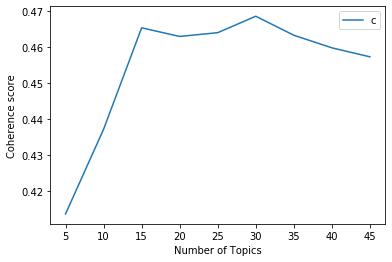

In [32]:
# Show graph
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, " has Coherence Value of", round(cv, 4))

Number of Topics = 5  has Coherence Value of 0.4136
Number of Topics = 10  has Coherence Value of 0.4372
Number of Topics = 15  has Coherence Value of 0.4654
Number of Topics = 20  has Coherence Value of 0.463
Number of Topics = 25  has Coherence Value of 0.464
Number of Topics = 30  has Coherence Value of 0.4686
Number of Topics = 35  has Coherence Value of 0.4633
Number of Topics = 40  has Coherence Value of 0.4598
Number of Topics = 45  has Coherence Value of 0.4573


# 6. Optimal LDAMallet model with 5 topics

In [24]:
pyLDAvis.enable_notebook()
lda_model_5=model_list[0]
optmodel_5 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_5)
vis_5= pyLDAvis.gensim.prepare(optmodel_5, corpus, id2word, mds='mmds')
vis_5

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.092135  0.175389       1        1  22.445445
1     -0.076045 -0.173672       2        1  22.080345
2     -0.204120 -0.000201       3        1  20.253071
0      0.209827 -0.127543       4        1  18.831302
4      0.162473  0.126027       5        1  16.389837, topic_info=             Term          Freq         Total Category  logprob  loglift
285       project  15045.000000  15045.000000  Default  30.0000  30.0000
1699       specie   4858.000000   4858.000000  Default  29.0000  29.0000
152        forest   3943.000000   3943.000000  Default  28.0000  28.0000
174        impact   9610.000000   9610.000000  Default  27.0000  27.0000
768       service   7001.000000   7001.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
283       process    843.393053   3027.985435   Topic5  -5.3445   0.5303
146         final    816.361225   3186.363045   Topic5  -5.3770   0.4467
182   information    844.474326   4197.897811   Topic5  -5.3432   0.2049
298        record    814.198678   3866.003648   Topic5  -5.3797   0.2507
132      evidence    819.605044   5191.024495   Topic5  -5.3731  -0.0374

[520 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
10872      4  0.919946  abruptness
1756       2  1.000993   abundance
10874      4  0.996608     accrual
3          1  0.182708        acre
3          3  0.817319        acre
...      ...       ...         ...
400        2  0.483436        year
400        3  0.090801        year
400        4  0.137837        year
400        5  0.100359        year
11030      5  0.924836       zonal

[818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

# 6. Optimal LDAMallet model with 15 topics

In [25]:
pyLDAvis.enable_notebook()
lda_model_15=model_list[2]
optmodel_15 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_15)
vis_15= pyLDAvis.gensim.prepare(optmodel_15, corpus, id2word, mds='mmds')
vis_15

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.059741  0.256088       1        1  9.685276
7      0.004844 -0.305555       2        1  9.339690
11    -0.011599 -0.145817       3        1  8.390151
3      0.101947  0.050046       4        1  8.314759
1      0.215959 -0.023669       5        1  8.242651
12     0.164127 -0.296734       6        1  8.095355
4     -0.043651  0.347501       7        1  7.580571
5      0.179409 -0.167803       8        1  7.116838
13    -0.210121 -0.108936       9        1  5.393355
6      0.247161  0.262730      10        1  5.165401
0      0.351134 -0.007914      11        1  5.059086
8     -0.256243  0.135427      12        1  4.803177
14    -0.344620  0.011176      13        1  4.593557
2     -0.204172  0.289946      14        1  4.123982
9     -0.253915 -0.296485      15        1  4.096151, topic_info=             Term          Freq         Total Category  logprob  loglift
285       project  15007.000000  15007.000000  Default  30.0000  30.0000
1334        water   5838.000000   5838.000000  Default  29.0000  29.0000
127      emission   5217.000000   5217.000000  Default  28.0000  28.0000
768       service   6945.000000   6945.000000  Default  27.0000  27.0000
118      document   4606.000000   4606.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
252       opinion    280.639783   2692.900764  Topic15  -5.0582   0.9338
528   educational    338.514914   7592.131361  Topic15  -4.8707   0.0848
292       purpose    235.868456   2954.040846  Topic15  -5.2320   0.6675
259          part    231.500522   3008.504763  Topic15  -5.2507   0.6305
197         issue    232.592505   5421.834350  Topic15  -5.2460   0.0462

[1537 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
8704       7  0.920815    abdicate
6024       1  0.980190    abeyance
8705       7  1.000886  abstention
1756       4  0.176353   abundance
1756       5  0.806600   abundance
...      ...       ...         ...
400       12  0.060232        year
400       13  0.043418        year
400       14  0.050696        year
400       15  0.004266        year
11538     13  0.913961         zar

[3248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 8, 12, 4, 2, 13, 5, 6, 14, 7, 1, 9, 15, 3, 10])

In [26]:
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 8. Find Dominant Topic For Each Document with LDA 15 topics

In [27]:
def format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optmodel_5, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7072,"project, agency, action, impact, forest, environmental, area, service, effect, decision","[raghupathi, wullianallur 4/28/2019, for educational only, montana environmental information center v. united s..., not reported in fed...., 2013 wl 11323877, only the west citation is currently available., united s district court, d. montana,, great falls division., montana environmental information center, et al. s,, v., united s bureau of land management, et al. s,, american petroleum institute, et al., –intervenors., v., no. cv-11-15-gf-seh, |, filed 06/14/2013, attorneys and firms, e..."
1,1,0.0,0.4919,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company","[raghupathi, wullianallur 4/28/2019, for educational only, exxon mobil corporation v. attorney general, 479 mass. 312, 94 n.e.3d 786, 479 mass. 312, supreme judicial court of massachtts,, suffolk.., exxon mobil corporation, v., attorney general., sjc–12376, |, argued december 5, 2017., |, decided april 13, 2018., synopsis background: fossil fuel company moved to set aside attorney general civil investigative demand for documents and information, relating, to, company, knowledge, and, activi..."
2,2,0.0,0.4646,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company","[raghupathi, wullianallur 4/28/2019, for educational only, people of of california v. general motors corp., not reported in f.supp.2d, 2007 wl 2726871, only the west citation is currently available., united s district court,, n.d. california., people of the of california, ,, v., general motors corporation, et al., s., no. c06–05755 mjj., |, sept. 17, 2007., attorneys and firms, kenneth p. alex, california department of justice, harrison martin pollak, janill l. richards, california attor..."
3,3,2.0,0.7253,"project, agency, action, impact, forest, environmental, area, service, effect, decision","[raghupathi, wullianallur 4/28/2019, for educational only, national audubon society v. kempthorne, slip copy, 2006 wl 8438583, only the west citation is currently available., united s district court, d. alaska., national audubon society; alaska wilderness league; center for biological diversity; natural resources defense council; northern alaska environmental center; sierra club; and the wilderness society, s,, v., dirk kempthorne, 1, secretary of the interior; henri bisson, director, bure..."
4,4,1.0,0.7808,"specie, action, service, agency, population, water, habitat, year, fish, conservation","[raghupathi, wullianallur 4/28/2019, for educational only, alaska oil and gas ass'n v. pritzker, not reported in f.supp.3d, 2014 wl 3726121, only the west citation is currently available., united s district court, d. alaska., alaska oil and gas association, et al., s,, v., penny pritzker, u.s. secretary of commerce, et al., s., of alaska, ,, v., national marine fisheries service, et al., s., north slope borough, et al., s,, v., penny pritzker, et al., s., nos. 4:13–cv–00018–rrb, 4:13–cv–00..."
5,5,0.0,0.6287,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company","[raghupathi, wullianallur 4/28/2019, for educational only, conservation foundation, inc. v. u.s. e.p.a., 964 f.supp.2d 175, 77 erc 1705, 964 f.supp.2d 175, united s district court, d. massachtts., conservation foundation, inc., et al., s,, v., united s environmental protection, agency, lisa p. jackson, administrator, et al., s., c.a. no. 10–11455–mlw., |, aug. 29, 2013., synopsis background: rs of waterways and coastal wetlands, and organizations to which they belonged brought action agai..."
6,6,1.0,0.7606,"specie, action, service, agency, population, water, habitat, year, fish, conservation","[raghupathi, wullianallur 4/28/2019, for educational only, center for biological diversity v. salazar, 804 f.supp.2d 987, 804 f.supp.2d 987, united s district court, d. arizona., center for biological diversity, et al.,

# 9. Find case for spec keywords with LDAMallet 15 topics

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9383,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company","[raghupathi, wullianallur 4/28/2019, for educational only, in re pilgrim pride corp. securities litigation, not reported in f.supp.2d, fed. sec. l. rep. p 95,840, 2010 wl 3257369, united s district court,, e.d. texas,, marshall division., in re pilgrim pride corporation securities litigation., civil action no. 2:08–cv–419–tjw., |, aug. 17, 2010., attorneys and firms, elton joe kendall, kendall group, llp, dallas, tx, john j. rice, coughlin stoia geller rudman & robbins llp, san diego, ca,..."
1,1.0,0.9194,"specie, action, service, agency, population, water, habitat, year, fish, conservation","[raghupathi, wullianallur 5/1/2019, for educational only, trout unlimited v. lohn, 645 f.supp.2d 929, 645 f.supp.2d 929, united s district court, d. oregon., trout unlimited, pacific rivers council, pacific coast federation of fishermen associations, institute for fisheries resources, native fish society, oregon natural resources council, umpqua watersheds, and coast range association, s,, v., d. robert lohn, northwest regional administrator of national marine fisheries service, and, carlos..."
2,2.0,0.8501,"project, agency, action, impact, forest, environmental, area, service, effect, decision","[raghupathi, wullianallur 5/2/2019, for educational only, soda mountain wilderness council v. u.s. bureau of land..., 945 f.supp.2d 1162..., 945 f.supp.2d 1162, united s district court, d. oregon,, medford division., soda mountain wilderness council; oregon wild; klamath siskiyou wildlands, center; center for biological diversity; and cascadia wildlands project, s,, united s bureau of land management, ., v., no. 1:12–cv–434–cl., |, may 10, 2013., synopsis background: environmental organizat..."
3,3.0,0.9219,"project, impact, environmental, plan, water, emission, significant, ceqa, agency, public","[raghupathi, wullianallur 4/28/2019, for educational only, merced alliance for responsible growth v. city of merced, not reported in cal.rptr.3d..., 2012 wl 5984917, not officially published, only the west citation is currently available., california rules of court, rule 8.1115, restricts citation of unpublished opinions in california courts., court of appeal,, fifth district, california., merced alliance for responsible growth et al., s and appellants,, city of merced et al., s and respond..."
4,4.0,0.9692,"document, emission, section, agency, decision, order, standard, public, issue, educational","[raghupathi, wullianallur 5/1/2019, for educational only, center for biological diversity v. office of management..., not reported in..., 2009 wl 2940204, only the west citation is currently available., united s district court,, n.d. california., center for biological diversity, ,, v., office of management and budget, ., no. c07–4997 mhp ., |, aug. 25, 2009., |, as amended sept. 9, 2009., attorneys and firms, deborah ann sivas, environmental clinic, stanford, ca, justin augustine, vera pr..."


In [29]:
sent_topics_sorteddf_mallet2=sent_topics_sorteddf_mallet.sort_values('Topic_Perc_Contrib',ascending=False)

sent_topics_sorteddf_mallet2.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
4,4.0,0.9692,"document, emission, section, agency, decision, order, standard, public, issue, educational","[raghupathi, wullianallur 5/1/2019, for educational only, center for biological diversity v. office of management..., not reported in..., 2009 wl 2940204, only the west citation is currently available., united s district court,, n.d. california., center for biological diversity, ,, v., office of management and budget, ., no. c07–4997 mhp ., |, aug. 25, 2009., |, as amended sept. 9, 2009., attorneys and firms, deborah ann sivas, environmental clinic, stanford, ca, justin augustine, vera pr..."
0,0.0,0.9383,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company","[raghupathi, wullianallur 4/28/2019, for educational only, in re pilgrim pride corp. securities litigation, not reported in f.supp.2d, fed. sec. l. rep. p 95,840, 2010 wl 3257369, united s district court,, e.d. texas,, marshall division., in re pilgrim pride corporation securities litigation., civil action no. 2:08–cv–419–tjw., |, aug. 17, 2010., attorneys and firms, elton joe kendall, kendall group, llp, dallas, tx, john j. rice, coughlin stoia geller rudman & robbins llp, san diego, ca,..."
3,3.0,0.9219,"project, impact, environmental, plan, water, emission, significant, ceqa, agency, public","[raghupathi, wullianallur 4/28/2019, for educational only, merced alliance for responsible growth v. city of merced, not reported in cal.rptr.3d..., 2012 wl 5984917, not officially published, only the west citation is currently available., california rules of court, rule 8.1115, restricts citation of unpublished opinions in california courts., court of appeal,, fifth district, california., merced alliance for responsible growth et al., s and appellants,, city of merced et al., s and respond..."
1,1.0,0.9194,"specie, action, service, agency, population, water, habitat, year, fish, conservation","[raghupathi, wullianallur 5/1/2019, for educational only, trout unlimited v. lohn, 645 f.supp.2d 929, 645 f.supp.2d 929, united s district court, d. oregon., trout unlimited, pacific rivers council, pacific coast federation of fishermen associations, institute for fisheries resources, native fish society, oregon natural resources council, umpqua watersheds, and coast range association, s,, v., d. robert lohn, northwest regional administrator of national marine fisheries service, and, carlos..."
2,2.0,0.8501,"project, agency, action, impact, forest, environmental, area, service, effect, decision","[raghupathi, wullianallur 5/2/2019, for educational only, soda mountain wilderness council v. u.s. bureau of land..., 945 f.supp.2d 1162..., 945 f.supp.2d 1162, united s district court, d. oregon,, medford division., soda mountain wilderness council; oregon wild; klamath siskiyou wildlands, center; center for biological diversity; and cascadia wildlands project, s,, united s bureau of land management, ., v., no. 1:12–cv–434–cl., |, may 10, 2013., synopsis background: environmental organizat..."


# 10. Topic distribution in 404 cases

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"project, agency, action, impact, forest, environmental, area, service, effect, decision",110.0,0.2723
1.0,0.0,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company",61.0,0.1510
2.0,0.0,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company",100.0,0.2475
3.0,2.0,"project, agency, action, impact, forest, environmental, area, service, effect, decision",61.0,0.1510
4.0,1.0,"specie, action, service, agency, population, water, habitat, year, fish, conservation",72.0,0.1782
...,...,...,...,...
399.0,1.0,"specie, action, service, agency, population, water, habitat, year, fish, conservation",NaN,NaN
400.0,0.0,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company",NaN,NaN
401.0,4.0,"document, emission, section, agency, decision, order, standard, public, issue, educational",NaN,NaN
402.0,2.0,"project, agency, action, impact, forest, environmental, area, service, effect, decision",NaN,NaN


In [31]:
df_dominant_topics2=df_dominant_topics.sort_values('Perc_Documents',ascending=False)
df_dominant_topics2.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"project, agency, action, impact, forest, environmental, area, service, effect, decision",110.0,0.2723
2.0,0.0,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company",100.0,0.2475
4.0,1.0,"specie, action, service, agency, population, water, habitat, year, fish, conservation",72.0,0.1782
1.0,0.0,"motion, fact, ment, educational, complaint, issue, action, interest, injury, company",61.0,0.1510
3.0,2.0,"project, agency, action, impact, forest, environmental, area, service, effect, decision",61.0,0.1510
